# Exploring LLM Dataset Creation and Evaluation

## Install the required libraries

In [3]:
!pip install -qqq huggingface-hub argilla "distilabel[huggingface]" accelerate openai datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 718.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.2/442.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from datasets import load_dataset
import argilla as rg
from google.colab import userdata

# Authenticate with Argilla
dataset = load_dataset("DIBT/10k_prompts_ranked")
column_names = dataset["train"].column_names
print(column_names)

/usr/local/lib/python3.10/dist-packages/argilla/_api/_token.py:83: UserWarning: 
The secrets ARGILLA_API_URL and does not exist in your Colab secrets.
  warnings.warn(f"\nThe secrets {name} and does not exist in your Colab secrets.")
/usr/local/lib/python3.10/dist-packages/argilla/_api/_token.py:83: UserWarning: 
The secrets ARGILLA_API_KEY and does not exist in your Colab secrets.
  warnings.warn(f"\nThe secrets {name} and does not exist in your Colab secrets.")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10331 [00:00<?, ? examples/s]

['prompt', 'quality', 'metadata', 'avg_rating', 'num_responses', 'agreement_ratio', 'raw_responses', 'kind', 'cluster_description', 'topic']


In [5]:
dataset['train'][0]

{'prompt': 'Provide step-by-step instructions on how to make a safe and effective homemade all-purpose cleaner from common household ingredients. The guide should include measurements, tips for storing the cleaner, and additional variations or scents that can be added. Additionally, the guide should be written in clear and concise language, with helpful visuals or photographs to aid in the process.',
 'quality': [{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb393a00',
   'value': '4',
   'status': 'submitted'},
  {'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e291889',
   'value': '4',
   'status': 'submitted'}],
 'metadata': '{"source": "ultrachat", "kind": "synthetic", "evolved_from": null}',
 'avg_rating': 5.0,
 'num_responses': 2,
 'agreement_ratio': 1.0,
 'raw_responses': [5, 5],
 'kind': 'synthetic',
 'cluster_description': 'Sustainable Packaging & Skin Care Products',
 'topic': 'Environmental Issues'}

In [8]:
import argilla as rg

# Initialize Argilla client

# Initialize the Argilla client

client = rg.Argilla(
    api_url=userdata.get('api_url'),
    api_key=userdata.get('api_key')
)

workspace = "argilla"
dataset_name = "DIBT_10k_prompts"

# Create a new Dataset
dataset = rg.Dataset(
    name=dataset_name,
    workspace=workspace,
    client=client
)

# Configure the dataset settings
dataset.settings.fields = [
    rg.TextField(name="id"),
    rg.TextField(name="instruction"),
    rg.TextField(name="generation"),
]

dataset.settings.questions = [
    rg.LabelQuestion(
        name="quality",
        labels=["👎", "👍"],
        title="Quality of the generated text",
    )
]

# Create the dataset on the server
dataset.create()

print(f"New dataset '{dataset_name}' created in workspace '{workspace}'")

New dataset 'DIBT_10k_prompts' created in workspace 'argilla'


In [9]:
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
from pathlib import Path

# Set the model name
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Set the directory where you want to save the model
local_model_path = "/content/tinyllama-1.1b-chat"

# Download the model
print(f"Downloading {model_name} to {local_model_path}...")
snapshot_download(repo_id=model_name, local_dir=local_model_path)

# Load the tokenizer and model to verify the download
print("Loading the model to verify the download...")
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model = AutoModelForCausalLM.from_pretrained(local_model_path)

print(f"Model {model_name} has been successfully downloaded and loaded.")

# Print the size of the downloaded model
total_size = sum(f.stat().st_size for f in Path(local_model_path).glob('**/*') if f.is_file())
print(f"Total size of the downloaded model: {total_size / 1e9:.2f} GB")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

eval_results.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

Loading the model to verify the download...
Model TinyLlama/TinyLlama-1.1B-Chat-v1.0 has been successfully downloaded and loaded.
Total size of the downloaded model: 2.20 GB


In [10]:
# Filter the dataset to pick the highest quality responses
filtered_dataset = load_dataset("DIBT/10k_prompts_ranked", split="train").filter(
    lambda r: float(r["avg_rating"]) >= 4 and int(r["num_responses"]) >= 2
)

Filter:   0%|          | 0/10331 [00:00<?, ? examples/s]

In [11]:
# View the features of your filtered dataset
filtered_dataset.features

{'prompt': Value(dtype='string', id='field'),
 'quality': [{'user_id': Value(dtype='string', id='question'),
   'value': Value(dtype='string', id='suggestion'),
   'status': Value(dtype='string', id='question')}],
 'metadata': Value(dtype='string', id='metadata'),
 'avg_rating': Value(dtype='float64', id=None),
 'num_responses': Value(dtype='int64', id=None),
 'agreement_ratio': Value(dtype='float64', id=None),
 'raw_responses': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'kind': Value(dtype='string', id=None),
 'cluster_description': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None)}

## Option A: Use local LLMs to create your pipelines

In [12]:
from distilabel.llms import TransformersLLM
from distilabel.pipeline import Pipeline
from distilabel.steps import (
    LoadDataFromDicts,
    TextGenerationToArgilla,
)
from distilabel.steps.tasks import TextGeneration
from datasets import load_dataset

# Subset your filtered dataset because of compute requirements. However, you can skip this step if you are not using a compute-constrained environment
filtered_dataset_12 = filtered_dataset.select(range(12))
filtered_dataset_12

Dataset({
    features: ['prompt', 'quality', 'metadata', 'avg_rating', 'num_responses', 'agreement_ratio', 'raw_responses', 'kind', 'cluster_description', 'topic'],
    num_rows: 12
})

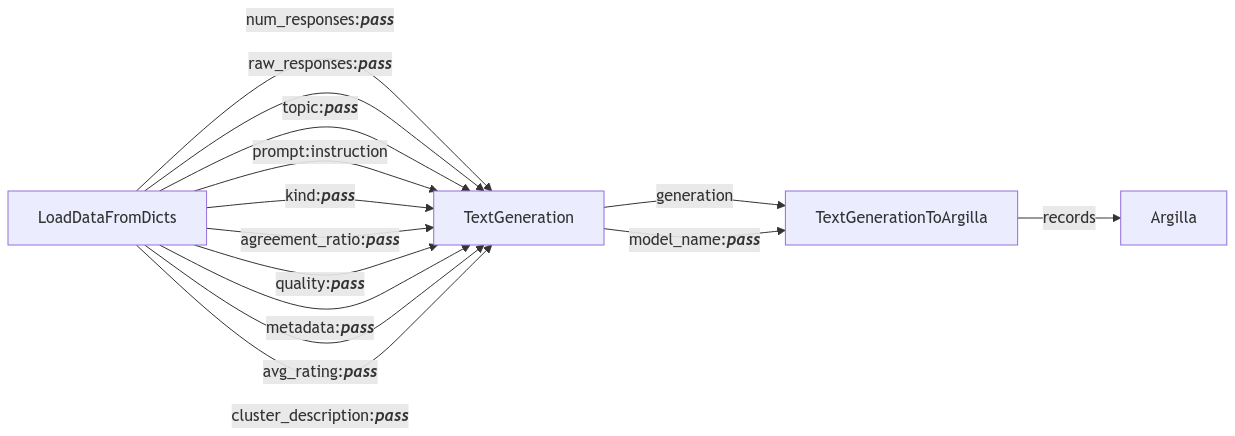

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 32>:49                                                                            │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │              client = <argilla.client.Argilla object at 0x7bd5205fb6a0>                      │ │
│ │        column_names = [                                                                      │ │
│ │                       │   'prompt',                                                          │ │
│ │                       │   'quality',                                                         │ │
│ │                       │   'metadata',                                                        │ │
│ │                       │   'avg_rating',                                                      │ │
│ │                       │   'num_responses',                                                   │ │
│ │                       │   'agreement_ratio',                                                 │ │
│ │                       │   'raw_responses',                                                   │ │
│ │                       │   'kind',                                                            │ │
│ │                       │   'cluster_description',                                             │ │
│ │                       │   'topic'                                                            │ │
│ │                       ]                                                                      │ │
│ │             dataset = Dataset(id=UUID('52fbeeb8-de11-4bb7-b977-d65777c98619')                │ │
│ │                       inserted_at=datetime.datetime(2024, 10, 20, 3, 16, 52, 268615)         │ │
│ │                       updated_at=datetime.datetime(2024, 10, 20, 3, 16, 53, 50642)           │ │
│ │                       name='DIBT_10k_prompts' status='ready' guidelines=None                 │ │
│ │                       allow_extra_metadata=False                                             │ │
│ │                       distribution=OverlapTaskDistributionModel(strategy='overlap',          │ │
│ │                       min_submitted=1)                                                       │ │
│ │                       workspace_id=UUID('1f4a8b2e-d004-43af-8fcb-79157dbf9641')              │ │
│ │                       last_activity_at=datetime.datetime(2024, 10, 20, 3, 16, 53, 50642))    │ │
│ │        dataset_name = 'DIBT_10k_prompts'                                                     │ │
│ │                exit = <IPython.core.autocall.ZMQExitAutocall object at 0x7bd566449240>       │ │
│ │    filtered_dataset = Dataset({                                                              │ │
│ │                       │   features: ['prompt', 'quality', 'metadata', 'avg_rating',          │ │
│ │                       'num_responses', 'agreement_ratio', 'raw_responses', 'kind',           │ │
│ │                       'cluster_description', 'topic'],                                       │ │
│ │                       │   num_rows: 1832                                                     │ │
│ │                       })                                                                     │ │
│ │ filtered_dataset_12 = Dataset({                                                              │ │
│ │                       │   features: ['prompt', 'quality', 'metadata', 'avg_rating',          │ │
│ │                       'num_responses', 'agreement_ratio', 'raw_responses', 'kind',           │ │
│ │                       'cluster_description', 'topic'],                                       │ │
│ │                       │   num_rows: 12                                                       │ │
│ │                       })                                                                     │ │
│ │         get_ipython = <bound method InteractiveShell.get_

In [14]:
# Create the pipeline
with Pipeline(
    name="prefs-with-tinyllama",
    description="Pipeline for building preference datasets using TinyLlama",
) as pipeline:
    load_dataset = LoadDataFromDicts(
        name="load_dataset",
        data=filtered_dataset_12,
        output_mappings={"prompt": "instruction"},
    )
    text_generation = TextGeneration(
        name="text_generation",
        llm=TransformersLLM(
            model=local_model_path,
            device_map="auto",  # This will use available GPU(s) efficiently
            torch_dtype="auto",  # This will use the appropriate dtype for the model
            trust_remote_code=True,  # This may be necessary for some models
            model_kwargs={
                "low_cpu_mem_usage": True,  # This can help with memory issues
            },
        ),
    )

    to_argilla = TextGenerationToArgilla(
        name="text_generation_to_argilla",
        dataset_name=dataset_name,
        dataset_workspace=workspace,
    )
    load_dataset >> text_generation >> to_argilla

# Run the pipeline
distiset = pipeline.run(
    parameters={
        "load_dataset": {
            "batch_size": 16,
        },
        "text_generation": {
            "llm": {
                "generation_kwargs": {
                    "max_new_tokens": 512,
                    "temperature": 0.7,
                    "do_sample": True,
                    "top_p": 0.95,
                    "top_k": 50,
                }
            }
        },
        "text_generation_to_argilla": {
            "api_url": userdata.get('argilla_api_url'),
            "api_key": userdata.get('argilla_api_key'),
            "dataset_name": dataset_name,
            "dataset_workspace": workspace,
        },
    }
)

## Option B: Use OpenAI LLM to create your pipeline

In [ ]:
from distilabel.llms import OpenAILLM
import os

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
# Create the pipeline
with Pipeline(
    name="prefs-with-openai",
    description="Pipeline for building preference datasets using OpenAI",
) as pipeline:
    load_dataset = LoadDataFromDicts(
        name="load_dataset",
        data=filtered_dataset_12,
        output_mappings={"prompt": "instruction"},
    )
    text_generation = TextGeneration(
        name="text_generation",
        llm=OpenAILLM(model="gpt-4")
    )

    to_argilla = TextGenerationToArgilla(
        name="text_generation_to_argilla",
        dataset_name=dataset_name,
        dataset_workspace=workspace,
    )
    load_dataset >> text_generation >> to_argilla

# Run the pipeline
distiset = pipeline.run(
    parameters={
        "load_dataset": {
            "batch_size": 16,
        },
        "text_generation": {
            "llm": {
                "generation_kwargs": {
                    "temperature": 0.7,
                }
            }
        },
        "text_generation_to_argilla": {
            "api_url": api_url,
            "api_key": api_key,
            "dataset_name": dataset_name,
            "dataset_workspace": workspace,
        },
    }
)

## Install Eleuther Evaluation Harness

In [ ]:
%%bash
git clone https://github.com/EleutherAI/lm-evaluation-harness
cd lm-evaluation-harness
pip install -e .

## Evaluate the LLM using Eleuther Evaluation Harness

In [ ]:
%%bash
lm_eval --model hf \
    --model_args pretrained=EleutherAI/pythia-160m,revision=step100000,dtype="float" \
    --tasks hellaswag \
    --device cuda \
    --batch_size auto:4 \
    --output_path hellaswag_test